In [75]:
import numpy as np
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random

input_size=2

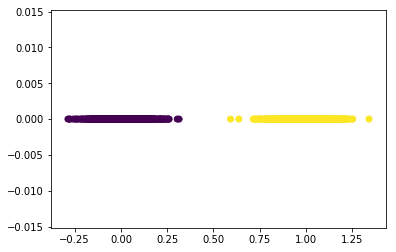

In [159]:
num_each_point = 700
one_hot = []
for i in range(num_each_point):
    one_hot.append([1,0])
for i in range(num_each_point):
    one_hot.append([0,1])

points = []
for point in one_hot:
    if point == [0,1]:
        points.append(np.random.normal(size=1, scale=0.1))
    if point == [1,0]:
        points.append(np.random.normal(size=1, scale=0.1) + np.array([1]))
points = np.array(points)

one_hot_colours = []
for i in range(len(one_hot)):
    if one_hot[i] == [0,1]:
        one_hot_colours.append(0)
    else:
        one_hot_colours.append(1)

zeros = [0 for i in points]
one_hot = np.array(one_hot)

        
plt.scatter(points[:,0],zeros, c=one_hot_colours)

In [179]:
one_hot_colours

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [169]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        self.en1 = nn.Linear(2, 10)
        self.en_mu = nn.Linear(10, 1)
        self.en_std = nn.Linear(10, 1)
        self.de1 = nn.Linear(1, 10)
        self.de2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def Z_reading(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)
        
    def encrypt(self, x):
        r1 = self.relu(self.en1(x))
        mu = self.en_mu(r1)
        logvar = self.en_std(r1)
        return mu, logvar
    
    def decrypt(self, z):
        r1 = self.relu(self.de1(z))
        r2 = self.sigmoid(self.de2(r1))
        return r2
    
    def forward(self, x):
        mu, logvar = self.encrypt(x)
        z = self.Z_reading(mu, logvar)
        reconstruction = self.decrypt(z)
        return reconstruction, mu, logvar
    
    def loss(self, reconstruction, x, mu, logvar):
        bce = torch.nn.functional.binary_cross_entropy(reconstruction, x.view(-1, input_size))
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= x.view(-1, input_size).data.shape[0] * input_size
        return bce + KLD
    
    def get_z(self, x):
        mu, logvar = self.encrypt(x)
        z = self.Z_reading(mu, std)
        return z
        

In [170]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(epochs):
    model.train()
    for epoch in range(epochs):
        for i in range(len(one_hot)):
            data = Variable(torch.from_numpy(one_hot[i]).float(), requires_grad = True)
            optimizer.zero_grad()
            results, mus, logvars = model(data)
            data1 = data.clone().detach()
            loss = model.loss(results, data1, mus, logvars)
            loss.backward()
        print('EPOCH: {} LOSS: {}'.format(epoch, loss.data))

In [175]:
train(20)

C:\Users\Stefan Clarke\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])) is deprecated. Please ensure they have the same size.


EPOCH: 0 LOSS: 0.7004820108413696
EPOCH: 1 LOSS: 0.6636384725570679
EPOCH: 2 LOSS: 0.655674934387207
EPOCH: 3 LOSS: 0.7079307436943054
EPOCH: 4 LOSS: 0.7056902647018433
EPOCH: 5 LOSS: 0.6244689226150513
EPOCH: 6 LOSS: 0.6777355670928955
EPOCH: 7 LOSS: 0.7044427394866943
EPOCH: 8 LOSS: 0.6372733116149902
EPOCH: 9 LOSS: 0.6771923303604126
EPOCH: 10 LOSS: 0.6732763051986694
EPOCH: 11 LOSS: 0.6669497489929199
EPOCH: 12 LOSS: 0.7054716944694519
EPOCH: 13 LOSS: 0.6168605089187622
EPOCH: 14 LOSS: 0.7021508812904358
EPOCH: 15 LOSS: 0.6329671144485474
EPOCH: 16 LOSS: 0.7014155387878418
EPOCH: 17 LOSS: 0.6365833282470703
EPOCH: 18 LOSS: 0.704717755317688
EPOCH: 19 LOSS: 0.704393744468689


In [176]:
model(torch.tensor([1,0]).float())

(tensor([0.4672, 0.4658], grad_fn=<SigmoidBackward>),
 tensor([0.3479], grad_fn=<AddBackward0>),
 tensor([-0.0571], grad_fn=<AddBackward0>))

In [177]:
model.loss(torch.tensor([1.0, 0.0]), torch.tensor([1.0, 0.0]), torch.tensor([1.0]), torch.tensor([1.0]))

C:\Users\Stefan Clarke\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])) is deprecated. Please ensure they have the same size.


tensor(0.4296)

In [178]:
data = Variable(torch.from_numpy(one_hot).float(), requires_grad = True)
model(data)

(tensor([[0.4699, 0.4652],
         [0.4645, 0.4644],
         [0.4325, 0.5052],
         ...,
         [0.4664, 0.4623],
         [0.4281, 0.5080],
         [0.4711, 0.4678]], grad_fn=<SigmoidBackward>), tensor([[0.3479],
         [0.3479],
         [0.3479],
         ...,
         [0.1379],
         [0.1379],
         [0.1379]], grad_fn=<AddmmBackward>), tensor([[-0.0571],
         [-0.0571],
         [-0.0571],
         ...,
         [-0.1214],
         [-0.1214],
         [-0.1214]], grad_fn=<AddmmBackward>))